[![CraigDoesData][logo]][link]

[logo]: ./img/logo.png
[link]: https://www.craigdoesdata.de/



# Mapping Avocado Prices in the US using Python - GeoPandas, GeoPy and Matplotlib
Data Analysis project mapping price data for avocados onto a map of the USA.

See the [blog post](https://towardsdatascience.com/mapping-avocado-prices-in-python-with-geopandas-geopy-and-matplotlib-c7e0ef08bc26) that accompanies this analysis on [Towards Data Science](https://towardsdatascience.com/mapping-avocado-prices-in-python-with-geopandas-geopy-and-matplotlib-c7e0ef08bc26).

#### Project status - Complete

![Avocado Prices](./img/Avocado_Prices_Display.jpg)

## Introduction
The purpose of this project was to take price data for avocados and to create an attractive and understandable visualisation representing that. I wanted to get to grips with creating maps in Matplotlib, as well as using geocoding locations - taking addresses in text form and finding their coordinates, enabling them to be represented spatially.


### Methods used
* EDA
* Data visualisation
* Geocoding
* Geographical mapping

    
### Technologies used
* Jupyter Notebook
* pandas
* Geopandas
* Geopy
* Matplotlib
* Shapely
* pickle


## Table of Contents

#### 1. Import and Cleaning
* 1.1 Library and Data Import
* 1.2 Data Inspection
* 1.3 Remove Unnecessary Columns

#### 2. Exploratory Data Analysis
* 2.1 Identify Unique Region Values
* 2.2 Statistical EDA
* 2.3 Visual EDA

#### 3. Create Average Price DataFrame
* 3.1 Create New DataFrame
* 3.2 Visual EDA

#### 4. Geocoding
* 4.1 - Call to Bing Maps API
* 4.2 - Pickle GeoData Dictionary
* 4.3 - Create DataFrame from Dictionary
* 4.5 - Tidy DataFrame

#### 5. Merging DataFrames
* 5.1 Confirm DataFrames Are Compatible
* 5.2 Merge DataFrames
* 5.3 Create Latitude and Longitude Columns
* 5.4 Convert pandas DataFrame to GeoPandas GeoDataFrame

#### 6. Create a Map of the United States Using Shapely

* 6.1 Import Shape File
* 6.2 Plot Shape File
* 6.3 List Names Contained in Shape File
* 6.4 Drop Unnecessary Entries
* 6.5 Convert Latitude and Longitude to Float
* 6.6 Remove NaN Entries

#### 7. Create the Visualisation
* 7.1 Synchronise GeoDataFrames
* 7.2 Use Matplotlib to Create the Visualisation

-------------------------------------

### 1. Import and Cleaning

##### 1.1 Library and Data Import
The first step is to import our libraries ([pandas](https://pandas.pydata.org/), [GeoPandas](https://geopandas.org/) and [matplotlib.pyplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html) to begin with) and read the CSV file containing our avocado pricing data into a pandas DataFrame.

In [3]:
# Importing libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from geopy.geocoders import Bing
from geopy.extra.rate_limiter import RateLimiter

import pickle

%matplotlib inline 
#So our plots display in the jupyter notebook environment

# Importing our data
data = pd.read_csv('./data/avocado.csv', index_col = 'Date')

##### 1.2 - Data Inspection
Now we will inspect the data to see what it looks like in our dataframe. We use the .head() method in pandas to see the first 5 rows of the data.

In [4]:
display(data.head())

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-12-27,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
2015-12-20,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2015-12-13,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
2015-12-06,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
2015-11-29,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


##### 1.3 - Remove Unnecessary Columns
That's too much data. Our aim is to make a geographic map showing average prices by region. We don't need to keep all of this data at this stage.

Dropping these columns from our DataFrame won't affect the CSV file, so if we realise later that there's some data we would like to keep, that data will still be there. 

In [5]:
columns_to_drop = ['Unnamed: 0', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type']

avo_df = data.drop(columns_to_drop, axis=1)
display(avo_df.head())

,AveragePrice,Total Volume,year,region
Date,,,,
2015-12-27,1.33,64236.62,2015,Albany
2015-12-20,1.35,54876.98,2015,Albany
2015-12-13,0.93,118220.22,2015,Albany
2015-12-06,1.08,78992.15,2015,Albany
2015-11-29,1.28,51039.60,2015,Albany


--------------------------------

### 2. Exploratory Data Analysis

##### 2.1 - Identify Unique Region Values
Now let's identify the unique values in the region column.

In [6]:
regions = avo_df.region.unique()

print(regions)

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']


##### 2.2 - Statistical EDA
Now would be a good time to carry out a little statistical EDA, to get an initial idea of the shape of our data. Let's take a look at the maximum, mean, median, minimum and standard deviation values, just to get a flavour of the spread of prices in our data.

In [7]:
print('Maximum = ' + str(avo_df.AveragePrice.max()))
print('Mean = ' + str(avo_df.AveragePrice.mean()))
print('Median = ' + str(avo_df.AveragePrice.median()))
print('Minimum = ' + str(avo_df.AveragePrice.min()))
print('Standard Deviation = ' +str(avo_df.AveragePrice.std()))

Maximum = 3.25
Mean = 1.4059784097758825
Median = 1.37
Minimum = 0.44
Standard Deviation = 0.40267655549555004


Just for interest, and to get to know our dataset better, let's find out the regions with the cheapest and most expensive avocados, according to our dataset.

In [8]:
display(avo_df[avo_df.AveragePrice == avo_df.AveragePrice.min()])
display(avo_df[avo_df.AveragePrice == avo_df.AveragePrice.max()])

,AveragePrice,Total Volume,year,region
Date,,,,
2017-03-05,0.44,64057.04,2017,CincinnatiDayton


,AveragePrice,Total Volume,year,region
Date,,,,
2016-10-30,3.25,16700.94,2016,SanFrancisco


##### 2.3 - Visual EDA

Now we can move on to performing some visual EDA. This is always an important step in getting a feel for a dataset. 

First of all, let's take a look at the distribution of prices using a histogram.

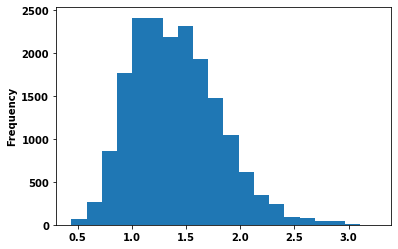

In [9]:
avo_df['AveragePrice'].plot(kind='hist', bins=20)

The visualisation we wish to create is going to have one datapoint for each region. Our DataFrame at present has many values for each region. How many? Let's find out!

In [10]:
avo_df['region'].value_counts().head()

HartfordSpringfield    338
LosAngeles             338
MiamiFtLauderdale      338
SanDiego               338
NewOrleansMobile       338
Name: region, dtype: int64

That's 338 records for each region. For our visualisation we don't need that level of detail, although it's nice to know that the [Hass Avocado Board](https://hassavocadoboard.com/) are taking their work seriously.

We want to produce a visualisation with one value for each region, and it makes sense to make that the average value over the whole period recorded. This will let us see, in a clear visual format, which regions are most and least expensive on average. We could split this out by year (or by type of avocado, or by size of bags sold, if we hadn't dropped that data from our DataFrame) if we wanted to. But the goal here is one beautiful map showing average prices for the period for which we have data.

--------------------------------

### 3. Create Average Price DataFrame

##### 3.1 - Create New DataFrame

In [11]:
group_by_region = avo_df.groupby(by=['region'])
avo_df_avg = group_by_region.mean()
avo_df_avg = avo_df_avg.drop(['year'], axis=1)

display(avo_df_avg.head())


,AveragePrice,Total Volume
region,,
Albany,1.561036,47537.869734
Atlanta,1.337959,262145.322041
BaltimoreWashington,1.534231,398561.891479
Boise,1.348136,42642.567308
Boston,1.530888,287792.854527


##### 3.2 - Visual EDA on the new DataFrame

Let's take a look at the distribution of prices for our new smaller dataset to see if the distribution looks roughly the same.

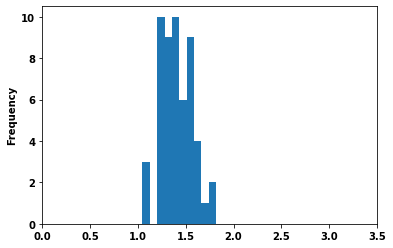

In [12]:
avo_df_avg['AveragePrice'].plot(kind='hist', xlim=(0,3.5), bins=10)

# We see that the peak is in the same area but that most of the outliers have been removed, as expected. There are much
# fewer datapoints in our new DataFrame as well, as we have reduced everything to one mean figure for each region for 
# each year

We see that the peak is in the same area but that most of the outliers have been removed, as expected. There are many fewer datapoints in our new DataFrame as well, as we have reduced everything to one mean figure for each region for each year

-------------------------------------

### 4. Geocoding

To produce a map visualisation we need more than just region names, as we have at present. Our next step is to pull in geodata for each of our regions. 

To do this we can use the [GeoPy](https://geopy.readthedocs.io/en/stable/) package, which will allow us to easily do some geocoding. We need to use an API with map data to pull the information from - more details can be found in the [GeoPy documentation](https://geopy.readthedocs.io/en/stable/). We will use the Bing Maps API as it works very well and access is free (although [setting up an API Key](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjzrOLv4ebqAhW0nVwKHQyGC0kQFjAAegQIBBAB&url=https%3A%2F%2Fdocs.microsoft.com%2Fen-us%2Fbingmaps%2Fgetting-started%2Fbing-maps-dev-center-help%2Fgetting-a-bing-maps-key&usg=AOvVaw1QYN8PRC1TLdTm67tpr_7n) is necessary)

##### 4.1 - Call to Bing Maps API

In [13]:
geolocator = Bing(api_key='AkibR2kEqwoSulS0vEks4jRx4LeRQac7SMobVUUbni_sz-KAYViMsK9egC1kNLbs', timeout=30)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2) # This prevents overloading the API with requests, but adds time to the process


regions_dict = {i : geolocator.geocode(i) for i in regions}

display(regions_dict)

{'Albany': Location(Albany, NY, United States, (42.65172576904297, -73.75509643554688, 0.0)),
 'Atlanta': Location(Atlanta, GA, United States, (33.7485466003418, -84.3915023803711, 0.0)),
 'BaltimoreWashington': Location(MD, United States, (39.175262451171875, -76.67152404785156, 0.0)),
 'Boise': Location(Boise, ID, United States, (43.61579132080078, -116.20157623291016, 0.0)),
 'Boston': Location(Boston, MA, United States, (42.35899353027344, -71.05863189697266, 0.0)),
 'BuffaloRochester': Location(Rochester, NY, United States, (43.15570831298828, -77.612548828125, 0.0)),
 'California': Location(CA, United States, (37.25467300415039, -119.61727905273438, 0.0)),
 'Charlotte': Location(Charlotte, NC, United States, (35.223785400390625, -80.84114074707031, 0.0)),
 'Chicago': Location(Chicago, IL, United States, (41.88322830200195, -87.63240051269531, 0.0)),
 'CincinnatiDayton': Location(Cincinnati, OH, United States, (39.10369873046875, -84.51361083984375, 0.0)),
 'Columbus': Location(Co

##### 4.2 - Pickle GeoData Dictionary
To ensure that we can save the raw geodata pulled from the API (so we don't have to repeatedly query it) or worry about losing access, let's use [pickle](https://docs.python.org/3/library/pickle.html) to save our dictionary as a .pickle file.

This is just like saving our progress at this point.

In [33]:
pickle_out = open("./data/dict.pickle","wb")
pickle.dump(regions_dict, pickle_out)
pickle_out.close()

In [15]:
# Let's bring it back in from its pickled form 
import pickle 

pickle_in = open("./data/dict.pickle","rb")
regions_dict_new = pickle.load(pickle_in)

##### 4.3 - Create DataFrame from Dictionary

In [16]:
regions_df = pd.DataFrame(regions_dict_new)

display(regions_df.head())

,Albany,Atlanta,BaltimoreWashington,Boise,Boston,BuffaloRochester,California,Charlotte,Chicago,CincinnatiDayton,...,SouthCarolina,SouthCentral,Southeast,Spokane,StLouis,Syracuse,Tampa,TotalUS,West,WestTexNewMexico
0,"Albany, NY, United States","Atlanta, GA, United States","MD, United States","Boise, ID, United States","Boston, MA, United States","Buffalo, NY, United States","CA, United States","Charlotte, NC, United States","Chicago, IL, United States","Cincinnati, OH, United States",...,"SC, United States","Dallas, TX, United States",United States,"Spokane, WA, United States","St Louis, MO, United States","Syracuse, NY, United States","Tampa, FL, United States",None,"Western, Zambia","NM, United States"
1,"(42.65155029296875, -73.75521087646484)","(33.74831008911133, -84.39111328125)","(39.183738708496094, -76.67420959472656)","(43.60768127441406, -116.19339752197266)","(42.35866165161133, -71.0567398071289)","(42.885440826416016, -78.87846374511719)","(37.25510025024414, -119.61752319335938)","(35.22285842895508, -80.83795928955078)","(41.88425064086914, -87.6324462890625)","(39.10712814331055, -84.5041275024414)",...,"(33.90385437011719, -80.89376831054688)","(32.71738815307617, -96.74552154541016)","(34.0, -85.0)","(47.65726089477539, -117.41227722167969)","(38.627750396728516, -90.1995620727539)","(43.050418853759766, -76.14737701416016)","(27.946529388427734, -82.45926666259766)",None,"(-15.655529975891113, 23.671653747558594)","(34.421321868896484, -106.10840606689453)"


##### 4.5 - Tidy DataFrame
This DataFrame has the information we want, but the formatting is not ideal at this point. Currently it is wide - we would like it to be tall instead, so it matches with our existing DataFrame. We can [melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) the DataFrame to achieve this. 

At the same time here we will give the columns some more meaningful names.

In [17]:
regions_df_melted = regions_df.iloc[1:2,:].melt()
regions_df_melted.columns = ['region', 'co-ordinates'] # give the columns meaningful names

display(regions_df_melted.head())

,region,co-ordinates
0,Albany,"(42.65155029296875, -73.75521087646484)"
1,Atlanta,"(33.74831008911133, -84.39111328125)"
2,BaltimoreWashington,"(39.183738708496094, -76.67420959472656)"
3,Boise,"(43.60768127441406, -116.19339752197266)"
4,Boston,"(42.35866165161133, -71.0567398071289)"


---------------------------------------

### 5. Merging DataFrames

##### 5.1 - Confirm DataFrames Are Compatible

The next step is to merge these two DataFrames (avo_df_avg - containing the price data, and regions_df_melted - containing the co-ordinates). Before we do that though, it is a good idea to confirm that we have the same list of regions. In this case let's just check the shape of the DataFrames.

In [18]:
print(avo_df_avg.shape)
print(regions_df_melted.shape)

(54, 2)
(54, 2)


##### 5.2 - Merge DataFrames

And now we can merge the DataFrames using [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) (as we are not specifying the 'how' argument, pandas will perform an [inner join](https://www.google.com/search?client=firefox-b-d&q=inner+join) by default).

In [20]:
df = pd.merge(avo_df_avg, regions_df_melted, left_on='region', right_on='region')
display(df.head())
display(df.shape)

,region,AveragePrice,Total Volume,co-ordinates
0,Albany,1.561036,47537.869734,"(42.65155029296875, -73.75521087646484)"
1,Atlanta,1.337959,262145.322041,"(33.74831008911133, -84.39111328125)"
2,BaltimoreWashington,1.534231,398561.891479,"(39.183738708496094, -76.67420959472656)"
3,Boise,1.348136,42642.567308,"(43.60768127441406, -116.19339752197266)"
4,Boston,1.530888,287792.854527,"(42.35866165161133, -71.0567398071289)"


(54, 4)

The new DataFrame also has 54 rows, so we can see no data has been lost during our merge.

##### 5.3 - Create Latitude and Longitude Columns
GeoPandas requires latitude and longitude as separate columns, so let's break the co-ordinates column apart using [.tolist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.tolist.html).

In [21]:
df[['latitude', 'longitude']] = pd.DataFrame(df['co-ordinates'].tolist(), index=df.index)
display(df.head())

,region,AveragePrice,Total Volume,co-ordinates,latitude,longitude
0,Albany,1.561036,47537.869734,"(42.65155029296875, -73.75521087646484)",42.651550,-73.755211
1,Atlanta,1.337959,262145.322041,"(33.74831008911133, -84.39111328125)",33.748310,-84.391113
2,BaltimoreWashington,1.534231,398561.891479,"(39.183738708496094, -76.67420959472656)",39.183739,-76.674210
3,Boise,1.348136,42642.567308,"(43.60768127441406, -116.19339752197266)",43.607681,-116.193398
4,Boston,1.530888,287792.854527,"(42.35866165161133, -71.0567398071289)",42.358662,-71.056740


##### 5.4 - Convert pandas DataFrame to GeoPandas GeoDataFrame

,region,AveragePrice,Total Volume,co-ordinates,latitude,longitude,geometry
0,Albany,1.561036,47537.869734,"(42.65155029296875, -73.75521087646484)",42.651550,-73.755211,POINT (-73.75521 42.65155)
1,Atlanta,1.337959,262145.322041,"(33.74831008911133, -84.39111328125)",33.748310,-84.391113,POINT (-84.39111 33.74831)
2,BaltimoreWashington,1.534231,398561.891479,"(39.183738708496094, -76.67420959472656)",39.183739,-76.674210,POINT (-76.67421 39.18374)
3,Boise,1.348136,42642.567308,"(43.60768127441406, -116.19339752197266)",43.607681,-116.193398,POINT (-116.19340 43.60768)
4,Boston,1.530888,287792.854527,"(42.35866165161133, -71.0567398071289)",42.358662,-71.056740,POINT (-71.05674 42.35866)


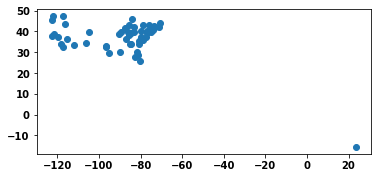

In [22]:
avo_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

display(avo_gdf.head())

# Plot the GeoDataFrame to see how the datapoints are distributed
avo_gdf.plot()

### 6. Create a Map of the United States Using Shapely

##### 6.1 - Import Shape Files

We have imported the [Point and Polygon classes from Shapely](https://shapely.readthedocs.io/en/latest/manual.html) to enable us to draw a map of the various US states using Pyplot. 

We will also import the USA Shapefiles [provided by the US Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) which we will be using as the basis of our map. These will be saved as a GeoDataFrame using GeoPandas.

In [23]:
usa = gpd.read_file('./shape_files/tl_2017_us_state.shp')
display(usa.head())

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


##### 6.2 - Plot Shape Files
Let's take a look at this shapefile and see what it contains.

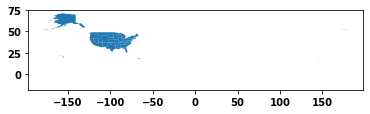

In [24]:
usa.plot()

OK - So we have some of the USA's overseas territories here making our map bigger than required. Let's see exactly what's in this Shape file. 

Our avocado data is only from the mainland United States, so we might need to trim this file to get a nice visualisation going.

##### 6.3 - List Names Contained in Shape File

In [25]:
display(usa.shape)
display(usa.NAME)

(56, 15)

0                                    West Virginia
1                                          Florida
2                                         Illinois
3                                        Minnesota
4                                         Maryland
5                                     Rhode Island
6                                            Idaho
7                                    New Hampshire
8                                   North Carolina
9                                          Vermont
10                                     Connecticut
11                                        Delaware
12                                      New Mexico
13                                      California
14                                      New Jersey
15                                       Wisconsin
16                                          Oregon
17                                        Nebraska
18                                    Pennsylvania
19                             

There are several entries here that are not included in the mainland United States, and which we won't need for our visualisation. 

Let's drop them from our DataFrame. We can do this simply by iterating through the rows of our DataFrame using this for loop.

##### 6.4 - Drop Unnecessary Entries

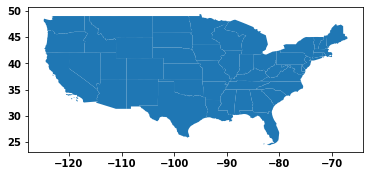

In [26]:
to_drop = ['Commonwealth of the Northern Mariana Islands', 'United States Virgin Islands', 
           'Hawaii', 'Alaska', 'Guam', 'Puerto Rico', 'American Samoa']

for index, row in usa.iterrows():
    if row['NAME'] in to_drop :
        usa.drop(index, inplace=True)

# Plot the updated GeoDataFrame
usa.plot()

That's better!

##### 6.5 - Convert Latitude and Longitude to Float

Our next step is to convert the latitude and longitude data types to float to make our lives easier.

In [27]:
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

display(df)

,region,AveragePrice,Total Volume,co-ordinates,latitude,longitude,geometry
0,Albany,1.561036,4.753787e+04,"(42.65155029296875, -73.75521087646484)",42.651550,-73.755211,POINT (-73.75521 42.65155)
1,Atlanta,1.337959,2.621453e+05,"(33.74831008911133, -84.39111328125)",33.748310,-84.391113,POINT (-84.39111 33.74831)
2,BaltimoreWashington,1.534231,3.985619e+05,"(39.183738708496094, -76.67420959472656)",39.183739,-76.674210,POINT (-76.67421 39.18374)
3,Boise,1.348136,4.264257e+04,"(43.60768127441406, -116.19339752197266)",43.607681,-116.193398,POINT (-116.19340 43.60768)
4,Boston,1.530888,2.877929e+05,"(42.35866165161133, -71.0567398071289)",42.358662,-71.056740,POINT (-71.05674 42.35866)
5,BuffaloRochester,1.516834,6.793630e+04,"(42.885440826416016, -78.87846374511719)",42.885441,-78.878464,POINT (-78.87846 42.88544)
6,California,1.395325,3.044324e+06,"(37.25510025024414, -119.61752319335938)",37.255100,-119.617523,POINT (-119.61752 37.25510)
7,Charlotte,1.606036,1.051939e+05,"(35.22285842895508, -80.83795928955078)",35.222858,-80.837959,POINT (-80.83796 35.22286)
8,Chicago,1.556775,3.955690e+05,"(41.88425064086914, -87.6324462890625)",41.884251,-87.632446,POINT (-87.63245 41.88425)
9,CincinnatiDayton,1.209201,1.317219e+05,"(39.10712814331055, -84.5041275024414)",39.107128,-84.504128,POINT (-84.50413 39.10713)


Some of these are NaNs (NULL entries) or look suspiciously round or otherwise mysterious - this is because our original data from the Hass Avocado Board includes several entries for larger regions and the total US ('GreatLakes', 'MidSouth', 'Northeast', 'Plains', 'SouthCentral', 'Southeast', 'TotalUS', 'West').

##### 6.6 - Remove NaN Entries

These need to be removed from our dataset, as they are duplicates and are going to cause us problems. It's always a good idea to understand your dataset. In this case, better late than never! 

Again, we will create a list with the entries to drop and loop over the rows of our DataFrame to get rid of the offending records.

In [28]:
to_drop = ['GreatLakes', 'Midsouth', 'Northeast', 'Plains', 'SouthCentral', 'Southeast', 'TotalUS', 'West']

for index, row in df.iterrows():
    if row['region'] in to_drop :
        df.drop(index, inplace=True)
#        
display(df)

,region,AveragePrice,Total Volume,co-ordinates,latitude,longitude,geometry
0,Albany,1.561036,4.753787e+04,"(42.65155029296875, -73.75521087646484)",42.651550,-73.755211,POINT (-73.75521 42.65155)
1,Atlanta,1.337959,2.621453e+05,"(33.74831008911133, -84.39111328125)",33.748310,-84.391113,POINT (-84.39111 33.74831)
2,BaltimoreWashington,1.534231,3.985619e+05,"(39.183738708496094, -76.67420959472656)",39.183739,-76.674210,POINT (-76.67421 39.18374)
3,Boise,1.348136,4.264257e+04,"(43.60768127441406, -116.19339752197266)",43.607681,-116.193398,POINT (-116.19340 43.60768)
4,Boston,1.530888,2.877929e+05,"(42.35866165161133, -71.0567398071289)",42.358662,-71.056740,POINT (-71.05674 42.35866)
5,BuffaloRochester,1.516834,6.793630e+04,"(42.885440826416016, -78.87846374511719)",42.885441,-78.878464,POINT (-78.87846 42.88544)
6,California,1.395325,3.044324e+06,"(37.25510025024414, -119.61752319335938)",37.255100,-119.617523,POINT (-119.61752 37.25510)
7,Charlotte,1.606036,1.051939e+05,"(35.22285842895508, -80.83795928955078)",35.222858,-80.837959,POINT (-80.83796 35.22286)
8,Chicago,1.556775,3.955690e+05,"(41.88425064086914, -87.6324462890625)",41.884251,-87.632446,POINT (-87.63245 41.88425)
9,CincinnatiDayton,1.209201,1.317219e+05,"(39.10712814331055, -84.5041275024414)",39.107128,-84.504128,POINT (-84.50413 39.10713)


### 7. Create the Plot

Now the real fun can begin. Before we start building our plot let's convert our DataFrames to GeoDataFrames.

##### 7.1 - Synchronise GeoDataFrames

At the same time, we will synchronise the [Coordinate Reference Systems](https://en.wikipedia.org/wiki/Spatial_reference_system) of the GeoDataFrames, so that they are on the same page regarding what the coordinates mean. This is very important if we want the datapoints to show up on the correct parts of our Shapefiles!


In [29]:
crs = {'init': 'epsg:4326'} # crs is the coordinate reference system - it's best to have both gdfs using the same one
avo_gdf = gpd.GeoDataFrame(df, crs=crs)
usa_gdf = gpd.GeoDataFrame(usa, crs=crs)

##### 7.2 - Use Matplotlib to Create the Final Visualisation

Each step is explained with a comment within the code where necessary. If any of the functions are unclear, the [matplotlib documentation](https://matplotlib.org/contents.html) is thorough and very accessible.

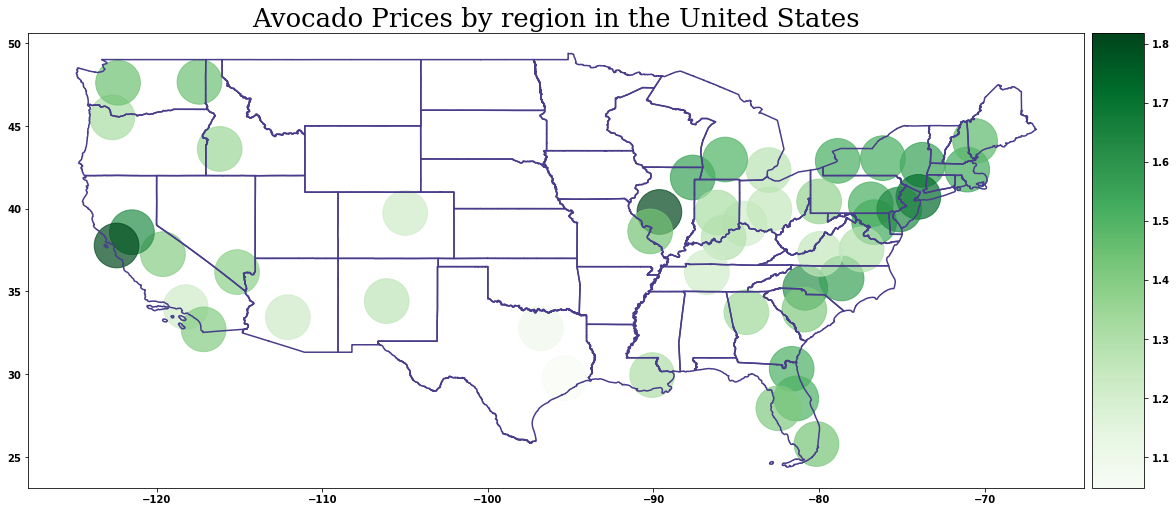

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable # This is a function to allow us to make the legend pretty

fig, ax = plt.subplots(figsize = (20,16)) 
plt.title('Avocado Prices by region in the United States', fontsize=26, fontfamily='serif')

#this part makes the legend the same size as our map, for prettiness
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

usa.boundary.plot(ax=ax, color='DarkSlateBlue') # using the boundary method here to get the outlines of the states, an aesthetic decision
avo_gdf.plot(cmap='Greens', column='AveragePrice', legend=True, ax=ax, s=2000, alpha=0.7, cax=cax)


# this saves a copy of the viz as a jpg so we can easily share it
plt.savefig('./img/Avocado_Prices.jpg', format='jpg') 

In [32]:
# Let's quickly export our DataFrame in its final form so we can use it again in future.

df.to_csv('./data/avocado_df.csv')

# And there we have it!

The visualisation we were dreaming of at the beginning of this project has now become a reality. What a glorious and satisfying outcome.

Thanks for coming with me on this journey! If you'd like to see any more of my Data Analytics work, just click the image below to visit [craigdoesdata.de](https://www.craigdoesdata.de), my portfolio website where you can see what else I've been working on and [get in touch](https://www.craigdoesdata.de/contact.html) with me.

Until next time!

[![CraigDoesData][logo]][link]

[logo]: ./img/logo.png
[link]: https://www.craigdoesdata.de/